## Topic EX: Further exploration of the interaction of repos with AI Agent

In [1]:
%matplotlib inline

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import combinations

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import community as community_louvain

In [2]:
data=pd.read_csv('repo_activity.csv')
data=data[['id','Efficiency','Popularity','stars','forks','pr_count','dominate_agent']]
X = data[["Efficiency", "Popularity"]].copy()
# data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# setting cluster count
k = 5

# Kmeans
kmeans = KMeans(
    n_clusters=k,
    n_init=10,
    random_state=42
)

labels = kmeans.fit_predict(X_scaled)

# record cluster value
data = data.copy()
data["cluster"] = labels

print("KMeans finished.")
data.head()

KMeans finished.


id  Efficiency  Popularity  stars  forks  pr_count dominate_agent  \
0   987641962   60.000000    0.000000    0.0    1.0         1    Claude_Code   
1   990249393   98.412293    3.377979    0.0    0.0         2    Claude_Code   
2  1009549206   99.453393    0.000000    0.0    0.0         1    Claude_Code   
3   983546765   36.940571   26.135815    0.0    0.0        37        Copilot   
4  1024190983   76.763779   11.549385    0.0    0.0         7    Claude_Code   

   cluster  
0        1  
1        1  
2        1  
3        0  
4        4

In [21]:
temp=data[(data['Popularity']>=35) & (data['Efficiency']>=50)].copy()
temp

id  Efficiency  Popularity    stars   forks  pr_count  \
386     1017722344   91.929940   41.063179      0.0     0.0       227   
490      964938887   53.058133   37.012263      1.0     0.0       169   
505     1001337788   96.823361   43.423588      0.0     0.0       366   
746      985613928   91.542424   38.419233      0.0     1.0       165   
809      826170402   54.744405   40.523968  16507.0  5289.0        58   
...            ...         ...         ...      ...     ...       ...   
113631   114691348   50.738255   35.969514     22.0    29.0       149   
113635   965385594   55.397741   36.763554     73.0    35.0       164   
113696   905753038   63.482054   40.090888      0.0     0.0       245   
114161   938384455   93.279728   35.274851      0.0     0.0       137   
114640   771479895   73.494302   35.977160   2784.0   144.0        61   

       dominate_agent  cluster  
386       Claude_Code        0  
490      OpenAI_Codex        0  
505      OpenAI_Codex        0  
746      OpenAI_Codex        0  
809      OpenAI_Codex        0  
...               ...      ...  
113631          Devin        0  
113635          Devin        0  
113696          Devin        0  
114161          Devin        0  
114640          Devin        0  

[900 rows x 8 columns]

In [4]:
all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")

In [22]:
#extract neccesary information from data
new = all_pr_df[all_pr_df['repo_id'].isin(temp['id'])].copy()
new = new[['repo_id','agent','user_id','merged_at']]

In [23]:
#Calculating connections between repos
temp['id'] = temp['id'].astype(int)
new['repo_id'] = new['repo_id'].astype(int)

# --- Step 1: Adding all repos as nodes ---
G = nx.Graph()
G.add_nodes_from(temp['id'].unique())

# --- Step 1.5: Giving nodes attributes ---
node_attr = (
    temp
    .set_index('id')[['Efficiency', 'Popularity']]
    .to_dict('index')
)
nx.set_node_attributes(G, node_attr)

# --- Step 2: adding weight for the connection by common agent ---
for agent, df_agent in new.groupby('agent'):
    repos = df_agent['repo_id'].unique()
    for a, b in combinations(sorted(repos), 2):
        if G.has_edge(a, b):
            G[a][b]['weight'] += 1
        else:
            G.add_edge(a, b, weight=1)

# --- Step 3: adding weight for the connection by common user ---
for user, df_user in new.groupby('user_id'):
    repos = df_user['repo_id'].unique()
    for a, b in combinations(sorted(repos), 2):
        if G.has_edge(a, b):
            G[a][b]['weight'] += 3
        else:
            G.add_edge(a, b, weight=3)
print(G)

Graph with 900 nodes and 381573 edges


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from complex_NX import NX_style
NX_style(
    G,
    mode="3d",  # "3d" (Plotly) or "2d" (PyVis)
    # ---- node visuals ----
    node_size='Popularity',
    node_color='Efficiency',
    node_style = "turbo",
    edge_color_attr = "weight",
    edge_style = "inferno",
    weak_weights=[1],
    weak_max_per_node=[0],
    simple=False,
    output_html= 'P_35_E_50',
    height = 1000,
    width = 1000,
    edge_shape = "arc",  # "straight" or "arc"
)

In [8]:
edges_remove=[(u,v) for u,v,w, in G.edges(data='weight') if w==1]
G.remove_edges_from(edges_remove)
deg=nx.degree_centrality(G)
G.remove_nodes_from(list(nx.isolates(G)))
print(G)

Graph with 54 nodes and 238 edges


In [9]:
nodes_deg_gt1=[n for n,d in G.degree() if d>0]

In [10]:
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")

In [11]:
repo_info=all_repo_df[all_repo_df['id'].isin(nodes_deg_gt1)].copy()
repo_info=repo_info.drop(columns=['url'])
repo_info=pd.merge(repo_info,temp,on='id')
repo_info = repo_info.drop(columns=["cluster",'stars_y','forks_y']).rename(columns={"forks_x": "forks", "stars_x": "stars"})
repo_info = repo_info.drop_duplicates(subset="id")
repo_info.head()

id      license                           full_name    language  \
0  1001337788         None  atariryuma/Everyone-s-Answer-Board        HTML   
1   845317529   Apache-2.0                 giselles-ai/giselle  TypeScript   
2    21764480  NOASSERTION                         hmislk/hmis        HTML   
3   136202695   Apache-2.0                       mlflow/mlflow      Python   
4  1000597137          MIT         AbuAli85/extra-contracts-yy  TypeScript   

    forks    stars  Efficiency  Popularity  pr_count dominate_agent  
0     0.0      0.0   96.823361   43.423588       366   OpenAI_Codex  
1    36.0    154.0   54.921165   52.325420       139   OpenAI_Codex  
2   104.0    167.0   95.294513   58.309717       421   OpenAI_Codex  
3  4716.0  21402.0   56.621614   50.913881        91        Copilot  
4     1.0      0.0   85.590606   42.804458       280   OpenAI_Codex

In [12]:
partition = community_louvain.best_partition(G, weight='weight')

In [13]:
# 原始 groups
groups = defaultdict(list)
for node, com in partition.items():
    groups[com].append(node)

# 按节点数量从大到小排序
sorted_com_list = sorted(groups.items(), key=lambda x: len(x[1]), reverse=True)

# 重新编号（0,1,2... 按规模排序）
groups_sorted = {i: nodes for i, (com, nodes) in enumerate(sorted_com_list)}

# 显示每个社区的规模
for idx, nodes in groups_sorted.items():
    print(f"Community {idx} (size: {len(nodes)}):")
    print(nodes[:20])   # 前 20 个
    print("---")

Community 0 (size: 17):
[np.int64(1001337788), np.int64(845317529), np.int64(21764480), np.int64(1009061088), np.int64(993205592), np.int64(777051546), np.int64(950132973), np.int64(999102560), np.int64(643978507), np.int64(988570153), np.int64(400215964), np.int64(1013210218), np.int64(669466632), np.int64(965250949), np.int64(496817075), np.int64(959682770), np.int64(941289933)]
---
Community 1 (size: 16):
[np.int64(136202695), np.int64(1000597137), np.int64(1015108803), np.int64(970331732), np.int64(985454802), np.int64(1001726147), np.int64(922867547), np.int64(981437432), np.int64(997625815), np.int64(970416658), np.int64(234231371), np.int64(941274176), np.int64(949218884), np.int64(1009862842), np.int64(994135021), np.int64(996535413)]
---
Community 2 (size: 4):
[np.int64(1007308309), np.int64(817096901), np.int64(1006232769), np.int64(995754354)]
---
Community 3 (size: 3):
[np.int64(1004086788), np.int64(1001353858), np.int64(1002040110)]
---
Community 4 (size: 2):
[np.int64(62

In [14]:
community_df = pd.DataFrame.from_dict(partition, orient="index", columns=["community"])
community_df.index.name = "repo"

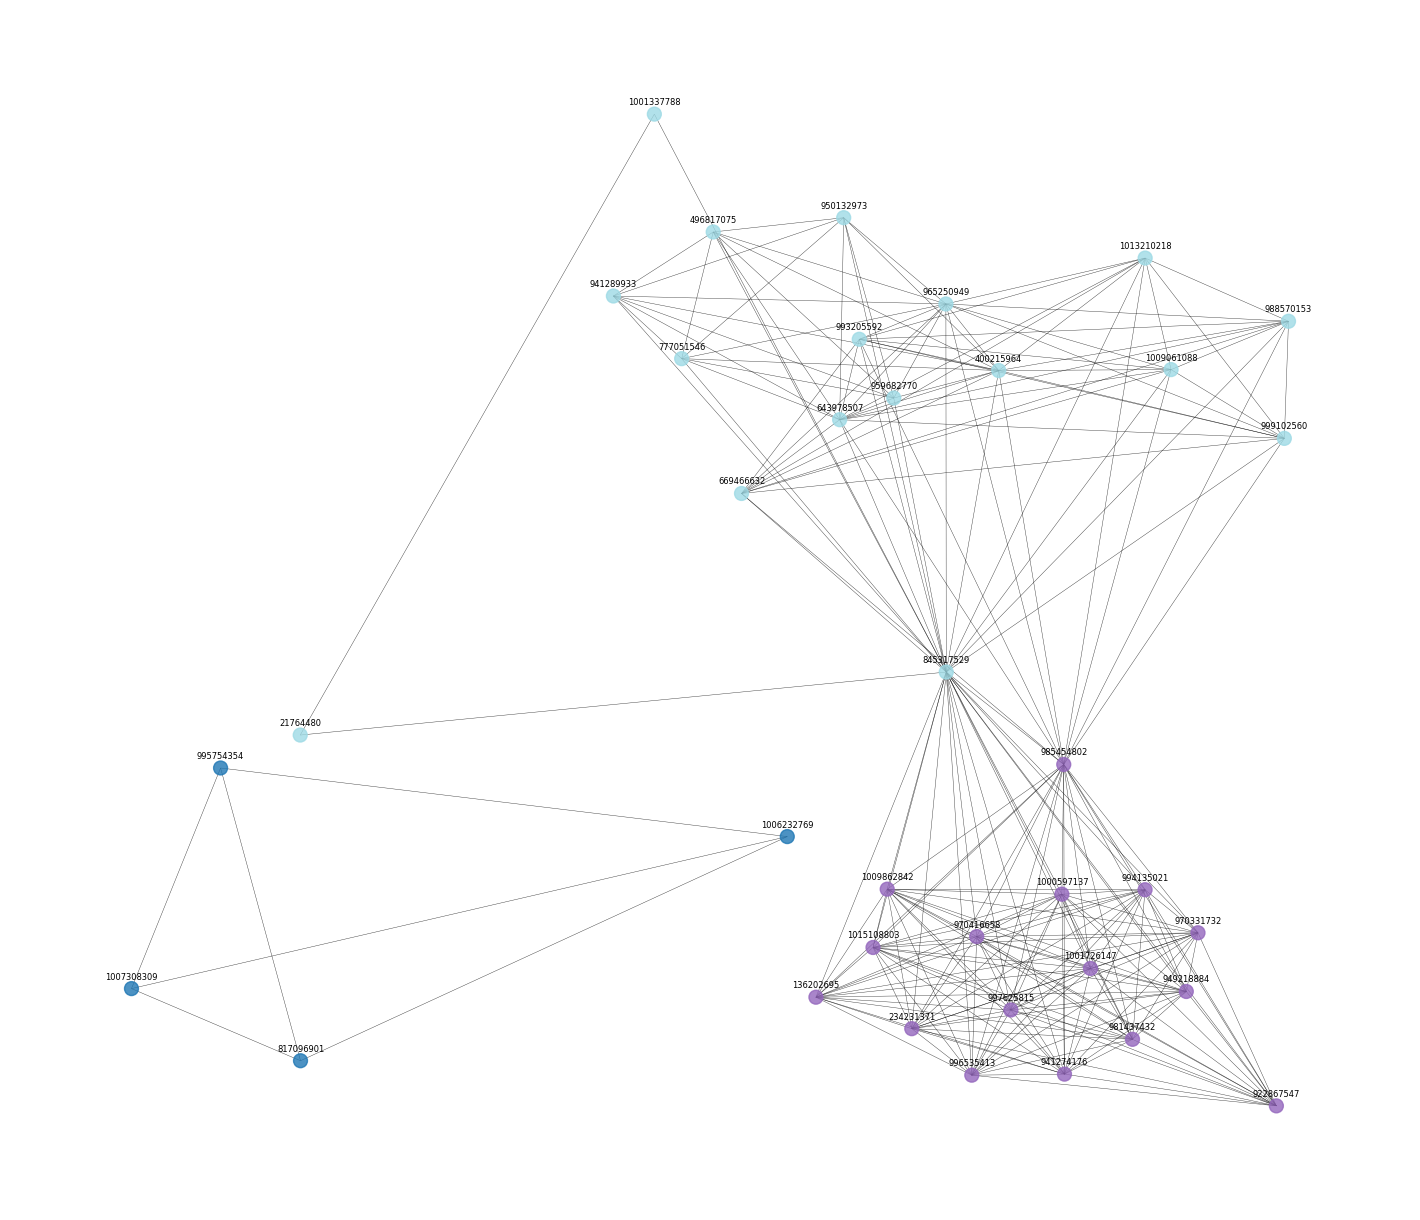

In [15]:
%matplotlib inline

# 1. Community detection（Louvain）
partition = community_louvain.best_partition(G, weight='weight')

# 2. Group nodes by community
from collections import defaultdict
groups = defaultdict(list)
for node, com in partition.items():
    groups[com].append(node)

# 3. Control the size of community to show
communities_to_hide = {com for com, nodes in groups.items() if len(nodes) in [2,3]}

# Filter nodes来创建子图
nodes_to_draw = [n for n in G.nodes() if partition[n] not in communities_to_hide]

# Create subgraph
G2 = G.subgraph(nodes_to_draw).copy()

# 4. 更新 partition（对于减少后的子图）
partition2 = {n: partition[n] for n in G2.nodes()}

# 5. Layout 用 G2 来算，否则有坐标漂移
pos = nx.spring_layout(G2, k=2.5, iterations=100, seed=42)

plt.figure(figsize=(14, 12))

# 6. Draw graph
nx.draw(
    G2, pos,
    node_color=[partition2[n] for n in G2.nodes()],
    cmap=plt.cm.tab20,
    node_size=100,
    width=0.3,
    alpha=0.8
)

# drawing labels
labels = {n: n for n in G2.nodes()}
label_pos = {n: (x, y+0.02) for n,(x,y) in pos.items()}  

nx.draw_networkx_labels(G2, label_pos, labels=labels, font_size=6)

plt.axis("off")
plt.show()


In [16]:
def show_community(x):
    community_x_ids = groups_sorted[x]
    community_x_df = repo_info[repo_info["id"].isin(community_x_ids)]
    return community_x_df

In [17]:
show_community(2)

id       license      full_name language  forks  stars  \
44  1007308309  BSD-2-Clause     splanck/vc        C    0.0    0.0   
45   817096901  BSD-2-Clause  splanck/vento        C    0.0    0.0   
46  1006232769  BSD-2-Clause  splanck/vlibc        C    0.0    0.0   
47   995754354  BSD-2-Clause   splanck/vush        C    0.0    0.0   

    Efficiency  Popularity  pr_count dominate_agent  
44   97.521122   52.755913      1124   OpenAI_Codex  
45   99.007967   46.164934       509   OpenAI_Codex  
46   97.873944   48.069584       640   OpenAI_Codex  
47   98.525339   49.532015       763   OpenAI_Codex